https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

In [71]:
# this function is for showing the spectrogram of an audio sample loaded using Torchaudio,
# it doesn't work for samples that are loaded using Librosa.

import matplotlib.pyplot as plt
import librosa
import torchaudio

#this auto implement


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


import librosa.display
import torchaudio.transforms as transforms

# @staticmethod
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    
    sig, sr = aud
    top_db = 80
    
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    
    return (spec)

# aud = torchaudio.load("./yeni.wav")

# spec = spectro_gram(aud)

# plot_spectrogram(spec[0])


In [72]:
# @staticmethod
import torch
from random import randint


def rechannel(aud, n_new_channel):
    
    sig, sr = aud

    #if new channel count equals old channel count
    if(sig.dim() == 1 ):
        n_current_channel = 1


    #detect current channel count
    elif(sig.dim() > 1 ):
        n_current_channel = sig.shape[0]

    if (n_current_channel == n_new_channel):
        return aud


    #new channel count required is greater than the current channel count
    elif(n_new_channel > n_current_channel):
        
        dif = n_new_channel - n_current_channel

        new_sig = sig[ randint(0, n_current_channel-1) ]
        new_sig = torch.unsqueeze(new_sig, dim=0)
        
        for i in range(dif-1):
            temp_sig = sig[ randint(0, n_current_channel-1) ]
            temp_sig = torch.unsqueeze(temp_sig, dim=0)
            
            new_sig = torch.cat((new_sig, temp_sig), dim=0)

        resig = torch.cat((sig, new_sig), dim= 0)
        
        

    elif n_new_channel < n_current_channel :

        n_mix_channel = n_current_channel - n_new_channel + 1

        mix_begin = randint(0, n_current_channel-n_mix_channel)
        mix_end = mix_begin + n_mix_channel

        mix_aud = torch.mean( sig[mix_begin:mix_end], dim=0 )
        mix_aud = torch.unsqueeze(mix_aud, dim=0)
        
        resig = torch.cat([sig[0:mix_begin,:], mix_aud, sig[mix_end:,:]])      

    return ((resig, sr))

In [73]:
# @staticmethod
# Bu fonksiyona gerek yok çünkü torchaudio.transforms.Resample kendisi birden fazla kanallı ses örneklerini
# alabiliyor ve sesin frekansını değiştirdikten sonra aynı kanal sayısı ile örneği geri döndürüyor

import torchaudio

def resample(aud, newsr):
    sig, sr = aud

    if( sr == newsr):
        return aud

    num_channels = sig.shape[0]

    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])

    if(num_channels > 1):
        retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
        resig = torch.cat([resig, retwo])

    return ((resig, newsr))

    

In [74]:

from random import randint

# @staticmethod
def pad_trunc(aud, max_ms:int):

    sig, sr = aud

    if sig.dim() > 1: # if there are more than one channel

        num_channel, sig_len = sig.shape

        max_len = sr//1000*max_ms

        if (sig_len > max_len):
            sig = sig[:, :max_len]

        elif(sig_len < max_len):

            pad_begin_len = randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            pad_begin = torch.zeros((num_channel, pad_begin_len))
            pad_end = torch.zeros((num_channel, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), dim=1)



    elif sig.dim()==1:             # if there is only one channel

        sig_len = sig.shape[0]
        max_len = sr//1000*max_ms

        if (sig_len > max_len):
            sig = sig[:max_len]

        elif(sig_len < max_len):

            pad_begin_len = randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            pad_begin = torch.zeros(pad_begin_len)
            pad_end = torch.zeros(pad_end_len)

            sig = torch.cat((pad_begin, sig, pad_end), dim=0)

    
    return (sig, sr)


In [75]:
import random

# @staticmethod
def time_shift(aud, shift_limit):
    sig, sr = aud
    _, sig_len = sig.shape

    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

In [76]:
import librosa.display
import torchaudio.transforms as transforms

# @staticmethod
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    
    sig, sr = aud
    top_db = 80
    
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    
    return (spec)
    

In [77]:
# @staticmethod
def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps =spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_masks_param = max_mask_pct * n_mels
    
    for _ in range(n_freq_masks):
        aug_spec = transforms.FrequencyMasking(freq_masks_param)(aug_spec, mask_value)
        time_mask_param = max_mask_pct * n_steps

    for _ in range(n_time_masks):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [78]:
import pandas as pd
import glob
import os

def create_df():

    file_path = []
    class_name = []
    
    for i in glob.glob("./datasets/donateacry_corpus_cleaned_and_updated_data/*"):
        
        if(os.path.isdir(i)):
            
            folder_base_name = os.path.basename(i)
            
            for file in glob.glob(i + "/*.wav"):

                file_path.append(file)
                class_name.append(folder_base_name)


    return pd.DataFrame({'relative_path':file_path, 'class_name':class_name})

In [79]:
import math, random
import numpy as np
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import librosa

class AudioUtil():
    @staticmethod
    def open(audio_file, sample_rate, mono_channel, use_librosa = True):
        
        if use_librosa == True:
            sig, sr = librosa.load(audio_file, sr=sample_rate, mono=mono_channel, res_type='kaiser_best')
            sig = torch.from_numpy(sig)

            if(sig.dim() == 1):
                sig = torch.unsqueeze(sig, dim=0)
        else:
            sig, sr = torchaudio.load(audio_file)

        return (sig, sr)

In [80]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
import os
import glob

class SoundDS(Dataset):

    def __init__(self, df):

        ########################
        self.use_librosa = True  
        #######################

        self.df = df
        # self.duration = 4000
        self.duration   = 7000            #miliseconds
        self.sr         = 22050           #44100

        self.num_channel = 1    
                                   
        self.shift_pct = 0.4
        self.classes = ["belly_pain", "burping", "discomfort", "hungry", "tired"]
                       

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        audio_file = self.df.loc[idx, 'relative_path']
        class_name = self.df.loc[idx, 'class_name']
        class_num = self.classes.index(class_name)

        aud = AudioUtil.open(audio_file,
                            sample_rate = self.sr,
                            mono_channel = self.num_channel==1,
                            use_librosa=self.use_librosa)

        

        if self.use_librosa == False:
        
            # reaud = resample(aud, self.sr)              
            # Yukarıdaki fonksiyon gerekesizdir. Çünkü torchaudio.transforms.Resample()() fonksiyonu 
            # kendisine birden fazla kanallı ses verisi alıp, geriye frekansı düzenlenmiş aynı kanal sayısında
            # örneği geri döndürmektedir.
            # Bu yüzden yukarıdaki fonksiyon yerine aşağıdaki fonksiyon kullanılmalıdır
            # Not: torchaudio.transforms sınıfı birden fazla kanallı ses verisi ile çalışabilmektedir.

            aud = torchaudio.transforms.Resample(aud[1], self.sr)(aud), self.sr


        rechan = rechannel(aud, self.num_channel)
        # print(rechan[0].shape)

        dur_aud = pad_trunc(rechan, self.duration)
        # print(dur_aud[0].shape)

        shift_aud = time_shift(dur_aud, self.shift_pct)
        # print(shift_aud[0].shape)

        sgram = spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)

        aug_sgram = spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
        
        return aug_sgram, class_num



In [81]:

from torch.utils.data import random_split

df = create_df()

myds = SoundDS( df )


num_items = len(myds)
num_train = round(num_items * 0.8) # 0.8
num_val = num_items - num_train

# val_ds:abbreviation for validation data set
train_ds, val_ds = random_split(myds,[num_train, num_val])


train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=8, shuffle=False) #bacth_size 16

In [82]:
it = iter(val_dl)
s, c = it.next()
print(s.shape)

torch.Size([8, 1, 64, 301])


In [83]:
# CREATE A CONVOLUTIONAL MODEL CLASS

import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

class Classifier(nn.Module):

    def __init__(self, n_channel):
        super(Classifier, self).__init__()

        conv_layers = []

        self.relu = nn.ReLU()

        # First convolution block
        self.conv1 = nn.Conv2d(n_channel, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        # self.relu layer
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers.extend( [self.conv1, self.relu, self.bn1] )

        # Second convolution block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        # self.relu layer
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers.extend( [self.conv2, self.relu, self.bn2] )


        # Third convolution block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        #self.relu layer
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a= 0.1)
        self.conv3.bias.data.zero_()
        conv_layers.extend( [self.conv3, self.relu, self.bn3] )

        # Fourth convolution block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        #self.relu layer
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a = 0.1)
        self.conv4.bias.data.zero_()
        conv_layers.extend( [self.conv4, self.relu, self.bn4] )

        # Last step for classification
        # Fully Connected Linear Layer

        # Downsizing with pooling
        self.avgPool = nn.AdaptiveAvgPool2d(output_size=1)
        
        #flattening for input to linear layer
        self.flatten = nn.Flatten(1, -1)

        self.linear_layer = nn.Linear(in_features=64, out_features=5)

        conv_layers.extend([self.avgPool, self.flatten, self.linear_layer])

        #The list of conv_layer is unpacked and sent
        self.conv = nn.Sequential(*conv_layers) # nn.Squential() gets *args or OrderedDict

    def forward(self, inputs):
        
        return self.conv(inputs)


# Create the model and put it on the GPU if available
myModel = Classifier(n_channel=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

myModel = myModel.to(device)

# Check that it is on Cuda
next(myModel.parameters()).device


device(type='cuda', index=0)

In [84]:
# import torch.nn.functional as F
# from torch.nn import init
# import torch.nn as nn

# # ----------------------------
# # Audio Classification Model
# # ----------------------------
# class AudioClassifier (nn.Module):
#     # ----------------------------
#     # Build the model architecture
#     # ----------------------------
#     def __init__(self):
#         super().__init__()
#         conv_layers = []

#         # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
#         self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
#         self.relu1 = nn.ReLU()
#         self.bn1 = nn.BatchNorm2d(8)
#         init.kaiming_normal_(self.conv1.weight, a=0.1)
#         self.conv1.bias.data.zero_()
#         conv_layers += [self.conv1, self.relu1, self.bn1]

#         # Second Convolution Block
#         self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
#         self.relu2 = nn.ReLU()
#         self.bn2 = nn.BatchNorm2d(16)
#         init.kaiming_normal_(self.conv2.weight, a=0.1)
#         self.conv2.bias.data.zero_()
#         conv_layers += [self.conv2, self.relu2, self.bn2]

#         # Third Convolution Block
#         self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
#         self.relu3 = nn.ReLU()
#         self.bn3 = nn.BatchNorm2d(32)
#         init.kaiming_normal_(self.conv3.weight, a=0.1)
#         self.conv3.bias.data.zero_()
#         conv_layers += [self.conv3, self.relu3, self.bn3]

#         # Fourth Convolution Block
#         self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
#         self.relu4 = nn.ReLU()
#         self.bn4 = nn.BatchNorm2d(64)
#         init.kaiming_normal_(self.conv4.weight, a=0.1)
#         self.conv4.bias.data.zero_()
#         conv_layers += [self.conv4, self.relu4, self.bn4]

#         # Linear Classifier
#         self.ap = nn.AdaptiveAvgPool2d(output_size=1)

#         self.lin = nn.Linear(in_features=64, out_features=5)
        
#         # Wrap the Convolutional Blocks
#         self.conv = nn.Sequential(*conv_layers)
 
#     # ----------------------------
#     # Forward pass computations
#     # ----------------------------
#     def forward(self, x):
#         # Run the convolutional blocks
#         x = self.conv(x)

#         # Adaptive pool and flatten for input to linear layer
#         x = self.ap(x)
#         x = x.view(x.shape[0], -1)

#         # Linear layer
#         x = self.lin(x)

#         # Final output
#         return x

# # Create the model and put it on the GPU if available
# myModel = AudioClassifier()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# myModel = myModel.to(device)

# # Check that it is on Cuda
# next(myModel.parameters()).device
        




Epoch: 0, Loss: 1.48, Accuracy: 0.48
Epoch: 1, Loss: 0.87, Accuracy: 0.83
Epoch: 2, Loss: 0.70, Accuracy: 0.83
Epoch: 3, Loss: 0.70, Accuracy: 0.83


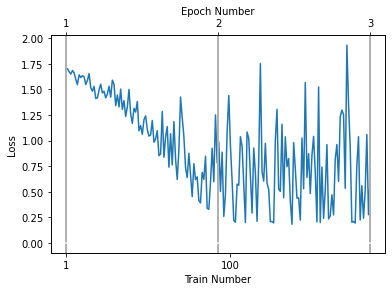

In [85]:
# ----------------------------
# Training Loop
# ----------------------------
from distutils.fancy_getopt import wrap_text
from sched import scheduler
import sys
import matplotlib.pyplot as plt
import torch.nn as nn
import os
from torch.utils.tensorboard import SummaryWriter
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup

writer = SummaryWriter("runs/Cry_Classification/writer")
writer2 = SummaryWriter("runs/Cry_Classification/writer2")

if not os.path.exists('./check_points_for_classification'):
    os.mkdir('./check_points_for_classification')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

losses = []


def training(model:nn.Module, train_dl, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    #this is original scheduler and not a good for this model and dataset
    # torch_lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01,
    #                                                 steps_per_epoch=int(len(train_dl)),
    #                                                 epochs=num_epochs,
    #                                                 anneal_strategy='linear')

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer,
                                                                gamma=0.99)
    # scheduler = create_lr_scheduler_with_warmup(torch_lr_scheduler,
    #                                            warmup_start_value=0.0,
    #                                            warmup_end_value=0.005,
    #                                            warmup_duration=7)

    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer,
    #                                                                  T_0=3,
    #                                                                  T_mult=2,
    #                                                                  eta_min=0.05)

    # scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer,
    #                                               )

    count = 0

    num_batches = len(train_dl)
    # scheduler(None)

    # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        sum_loss_every_4_batch = 0
        sum_correct_prediction_4_batch = 0
        sum_total_prediction_4_batch = 0

        # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            if(i+1)%16 == 0:
                # scheduler(None
                scheduler.step()
            
            count+=1

            # Get the input features and target labels, and put them on the GPU
            inputs = data[0].to(device)
            labels = data[1].to(device)
            

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # torch_lr_scheduler.step()

            losses.append(loss.cpu().data.numpy())
            

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()
            sum_loss_every_4_batch += loss.item()
            

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            sum_correct_prediction_4_batch += (prediction == labels).sum().item()
            sum_total_prediction_4_batch += prediction.shape[0]

            # writer.add_scalar("Learning Rate", scheduler.get_last_lr()[0], epoch*num_batches+i+1)  
            writer.add_scalar("Learning Rate", optimizer.param_groups[0]['lr'], count) 

            if (i+1) % 4 == 0:    # print every 10 mini-batches
                avg_loss = sum_loss_every_4_batch/4
                avg_acc = sum_correct_prediction_4_batch/sum_total_prediction_4_batch

                #  print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
                writer.add_scalar('trainin loss - every 4 batch', avg_loss, epoch*num_batches+i+1)
                writer.add_scalar('accuracy - every 4 batch', avg_acc, epoch*num_batches+i+1)  

                sum_loss_every_4_batch = 0
                sum_correct_prediction_4_batch = 0
                sum_total_prediction_4_batch = 0

                
    

        # Print stats at the end of the epoch
        
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction

        writer2.add_scalar('training loss - end of every epoch', avg_loss, (epoch+1)*num_batches)
        writer2.add_scalar('accuracy - of end every epoch', acc, (epoch+1)*num_batches)

        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

        #save checkpoints after every epoch

        path = './check_points_for_classification/checkpoint_'+str(epoch+1)+'.pth'

        checkpoint = {"model_state": model.state_dict(),
                      "optim_state": optimizer.state_dict(),
                      "scheduler"  : scheduler.state_dict()
                      }

        torch.save(checkpoint, path)

    writer.close()
    writer2.close()

    if True:
        plt.plot([x for x in range(1,count+1)], losses)
        plt.xticks(np.arange(1,count+1, 99))
        plt.ylabel("Loss")
        plt.xlabel("Train Number")
        ay = plt.twiny()
        ay.set_xlabel("Epoch Number")
        ay.set_xticks(np.arange(1, num_epochs+1, 1))

        y = [0 for x in range(1, num_epochs)]
        epoch = [x for x in range(1, num_epochs)]
        ay.plot(epoch,y, color="white")
        
        ay.grid(True, linewidth=2)


num_epochs=4   # Just for demo, adjust this higher.

training(myModel, train_dl, num_epochs)



In [86]:
# ----------------------------
# Inference
# ----------------------------
from torch.utils.tensorboard import SummaryWriter
import copy
import torch

writer = SummaryWriter('runs/Cry_ClassificationTest/writer_epoch')
writer_batch = SummaryWriter('runs/Cry_ClassificationTest/writer_batch')

def inference (model:nn.Module, val_dl, model_no):
    correct_prediction = 0
    total_prediction = 0
    total_loss = 0.0
    model.eval()

    criterion = nn.CrossEntropyLoss()

    # Disable gradient updates
    with torch.no_grad():

        runningLoss = 0.0
        runningPredict  = 0
        runnigCorrectPredict = 0

        for i, data in enumerate(val_dl):
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            total_loss += loss

            runnigCorrectPredict += (prediction == labels).sum().item()
            runningPredict       += prediction.shape[0]
            runningLoss += loss
            
            n = 1
            if i%n==0:
                writer_batch.add_scalar("model_"+str(model_no)+" accuracy every n_batch", runnigCorrectPredict/runningPredict, i+1)
                writer_batch.add_scalar("model_"+str(model_no)+" loss every n_batch", runningLoss/(n), i+1)
                runningLoss = 0.0
                runningPredict  = 0
                runnigCorrectPredict = 0
    
    acc = correct_prediction/total_prediction
    
    print("model_"+str(model_no)+ f' Loss: {total_loss/len(val_dl):.2f} Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set

models = []
model_x = Classifier(n_channel=1).to(device)

for model_no in range(1,5):
    path = 'check_points_for_classification/checkpoint_'+str(model_no)+'.pth'
    model_x.load_state_dict( torch.load(path)["model_state"] )
    models.append(copy.deepcopy(model_x))


for i in range(1,5):
    inference(models[i-1], val_dl, model_no = i)

model_1 Loss: 1.21 Accuracy: 0.77, Total items: 91
model_2 Loss: 0.70 Accuracy: 0.86, Total items: 91
model_3 Loss: 0.61 Accuracy: 0.85, Total items: 91
model_4 Loss: 0.60 Accuracy: 0.86, Total items: 91


In [17]:
import tensorboard

0

In [ ]:
# ----------------------------
# Inference
# ----------------------------

import torch.utils.tensorboard

def inference_one (model, data):
    correct_prediction = 0
    total_prediction = 0

    # Disable gradient updates
    with torch.no_grad():
        
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Get predictions
        outputs = model(inputs)

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]
        
    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

In [ ]:
#DENEME DENEME DENEME

import matplotlib.pyplot as plt
import librosa.display

aud = torchaudio.load("test.wav")

x, sr = aud

plt.subplot(2, 1, 1)

librosa.display.waveshow(aud[0].numpy())

plt.subplot(2,1,2)


reaud = resample(aud, sr)
rechan = rechannel(reaud, 2)

dur_aud = pad_trunc(rechan, 5000)
shift_aud = time_shift(dur_aud, 0.4)
sgram = spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
aug_sgram = spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

# print(dur_aud[0])
librosa.display.waveshow(shift_aud[0].numpy())

